<a href="https://colab.research.google.com/github/dobrotvorn/DataCon23/blob/main/HacatonNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Описание задания


Задание заключается в том, чтобы ...

### Описание данных
data.csv

Для всех образцов в датасете использовались наночастицы серебра Ag

---



*   Bacteria: бактериальная клетка-мишень
* NP_Synthesis: тип синтеза наночастиц
*drug: название лекарства
*drug class: класс лекарства
*Drug dose: доза препарата
*NP_concentration: концентрация НЧ
*NP_size: размер НЧ
*shape: форма НЧ
*method: метод определения антимикробной активности
*ZOI_drug, ZOI_NP, ZOI_drug_NP: зона ингибирования препарата, НЧ и их комбинации
*Fold increase in antibacterial activity (%): кратное увеличение *антибактериальной активности (%)
*дзета-потенциал;
*MDR: множественная лекарственная устойчивость резистентен ли обычный препарат к целевому патогену

---

bacterial_descriptors.csv


* Tax_id: id бактерии в базе данных NCBI
*Bacteria: название бактерии
*ingdom: царство бактерии
*subkingdom: подцарство бактерии
*clade: характеристика бактерии с точки зрения родственных взаимоотношений между таксономическими группами
*phylum: филум бактерии
*class: класс бактерии
*order: порядок бактерии
*family: семейство бактерии
*genus: род бактерии
*species: вид бактерии
*gram: результат реакции окрашивания по Грамму для бактерии
*min_Incub_period, avg_Incub_period, max_Incub_period h: характеристики инкубационного периода бактерии
*growth_temp, C: температура роста бактерии
*biosafety_level: уровень опасности бактерии
*isolated_from: источник


---

drug_descriptors.csv
*  drug: название лекарства
*chemID: id лекарства в базе данных CHEMBL
*prefered_name: название лекарства
*smiles: химическая формула лекарства

## Загрузка данных и библиотек

###Импортируем и скачиваем библиотеки

In [2]:
!pip install gdown -- quiet
!pip install pymatgen
!pip install rdkit
!pip install fancyimpute --quiet
!pip install shap
!pip install livelossplot --quiet

from IPython.display import clear_output
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import plotly

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin


import torch

import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import plotly
import scipy.stats as stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer
from IPython.display import display, HTML
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from fancyimpute import KNN
import pymatgen.core as mg
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import SimilarityMaps
from zipfile import ZipFile

%matplotlib inline
import pandas as pd
from IPython.display import clear_output
import numpy as np
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import  MinMaxScaler,PolynomialFeatures,StandardScaler
from sklearn.impute import  KNNImputer, SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, KBinsDiscretizer # говорят, он хорош для выбрасов
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import StratifiedKFold #так как у нас несбалансированные таргеты (много небольших цен и мало больших), возможно, стоит так стратифицировать.
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor, VotingRegressor
from sklearn.linear_model import SGDRegressor, RANSACRegressor, TheilSenRegressor, HuberRegressor, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Binarizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot



from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer
from IPython.display import display, HTML
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from fancyimpute import KNN
from re import A
import json
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
clear_output()

In [3]:

# тут захардкодим статичные переменные
global ordinal_encoder
global text_columns
global path2firstDb
global path2secondDb
global numerics
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
path2data = '/content/data.csv' if 'google.colab' in sys.modules else 'data.csv'
path2bac_descr = '/content/bacterial_descriptors.csv' if 'google.colab' in sys.modules else 'bacterial_descriptors.csv'
path2drug_descr = '/content/drug_descriptors.csv' if 'google.colab' in sys.modules else 'drug_descriptors.csv'

### Скачиваем данные

In [4]:
url1 = 'https://raw.githubusercontent.com/dataconHack/hackathon/main/data.csv'
url2 = 'https://raw.githubusercontent.com/dataconHack/hackathon/main/bacterial_descriptors.csv'
url3 = 'https://raw.githubusercontent.com/dataconHack/hackathon/main/drug_descriptors.csv'
output1 = 'data.csv'
output2 = 'bacterial_descriptors.csv'
output3 = 'drug_descriptors.csv'
gdown.download(url1, output1, quiet=True)
gdown.download(url2, output2, quiet=True)
gdown.download(url3, output3, quiet=True)
clear_output()

## Обработка данных

In [5]:
fdb = pd.read_csv(path2data)
fdb.head(3)

,Unnamed: 0.1,Unnamed: 0,Bacteria,NP_Synthesis,Drug,Drug_class_drug_bank,Drug_dose,NP_concentration,NP size_min,NP size_max,NP size_avg,shape,method,ZOI_drug,ZOI_NP,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check
0,0,86,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Amoxicillin,Lactams,NaN,NaN,4.0,10.0,8.0,spherical,MIC,32+,6.3,32+,NaN,1
1,1,87,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Penicillin,Carboxylic acids and derivatives,NaN,NaN,4.0,10.0,8.0,spherical,MIC,32+,6.3,32+,NaN,1
2,2,679,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Amoxicillin,Lactams,NaN,NaN,15.0,30.0,28.0,spherical,MIC,32+,25,32+,NaN,1


In [6]:
fdb_bak = pd.read_csv(path2bac_descr)
fdb_bak.head(3)

,Tax_id,Bacteria,kingdom,subkingdom,clade,phylum,class,order,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from
0,['470'],Acinetobacter baumannii,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Moraxellales,Moraxellaceae,Acinetobacter,Acinetobacter calcoaceticus/baumannii complex,n,24.0,36.0,48.0,37,2,urine
1,['715'],Actinobacillus pleuropneumoniae,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Actinobacillus,Actinobacillus pleuropneumoniae,n,24.0,36.0,48.0,37,2,lungs
2,['5599'],Alternaria alternata,Fungi,Dikarya,Opisthokonta,Ascomycota,Dothideomycetes,Pleosporales,Pleosporaceae,Alternaria,Alternaria alternata,NaN,48.0,192.0,336.0,30,2,food


In [7]:
fdb_drug = pd.read_csv(path2drug_descr)
#Добавляем дескрипторы из RDKit
descript = ['MolLogP', 'NumValenceElectrons', 'NumHeteroatoms', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds', 'TPSA', 'LabuteASA']
def get_descriptors_values(desc, mol):
    descriptors_values = []
    for descr in descript:
        descriptors_values.append(Descriptors.CalcMolDescriptors(mol)[descr])
    return descriptors_values
filled_descriptors_list = []
for item in fdb_drug['smiles']:
  mol = Chem.MolFromSmiles(f'{item}')
  descriptors_with_value = get_descriptors_values(descript, mol)
  filled_descriptors_list.append(descriptors_with_value)
fdb_drug_desc = pd.DataFrame(filled_descriptors_list, columns=descript)
fdb_drug = fdb_drug.join(fdb_drug_desc, how='outer')
fdb_drug.head(3)

,Unnamed: 0,drug,chemID,prefered_name,smiles,MolLogP,NumValenceElectrons,NumHeteroatoms,NumAromaticRings,NumHAcceptors,NumHDonors,NumRotatableBonds,TPSA,LabuteASA
0,0,Amoxicillin,CHEMBL1082,AMOXICILLIN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,0.0237,134,9,1,6,4,4,132.96,147.914892
1,1,Penicillin,CHEMBL1223,PENICILLIN G POTASSIUM,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,-3.4699,122,8,1,5,1,4,89.54,186.703333
2,2,Vancomycin,CHEMBL262777,VANCOMYCIN,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,0.1062,542,35,5,25,19,13,530.49,583.819675


Сольём три табличка в одну ( null не заполняли - лучше мб заполнить сразу же до мерджа)


In [8]:
db =  fdb.merge(fdb_bak, how='left', left_on='Bacteria', right_on='Bacteria').merge(fdb_drug, how='left', left_on='Drug', right_on='drug').drop(['Unnamed: 0.1', 'Unnamed: 0_x', 'Unnamed: 0_y', 'Drug'], axis=1)
db.head(30)

,Bacteria,NP_Synthesis,Drug_class_drug_bank,Drug_dose,NP_concentration,NP size_min,NP size_max,NP size_avg,shape,method,ZOI_drug,ZOI_NP,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check,Tax_id,kingdom,subkingdom,clade,phylum,class,order,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from,drug,chemID,prefered_name,smiles,MolLogP,NumValenceElectrons,NumHeteroatoms,NumAromaticRings,NumHAcceptors,NumHDonors,NumRotatableBonds,TPSA,LabuteASA
0,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Lactams,NaN,NaN,4.00,10.00,8.0,spherical,MIC,32+,6.3,32+,NaN,1,['562'],Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,n,48.00,84.00,120.0,37.0,2.0,urine,Amoxicillin,CHEMBL1082,AMOXICILLIN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,0.02370,134.0,9.0,1.0,6.0,4.0,4.0,132.96,147.914892
1,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Carboxylic acids and derivatives,NaN,NaN,4.00,10.00,8.0,spherical,MIC,32+,6.3,32+,NaN,1,['562'],Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,n,48.00,84.00,120.0,37.0,2.0,urine,Penicillin,CHEMBL1223,PENICILLIN G POTASSIUM,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,-3.46990,122.0,8.0,1.0,5.0,1.0,4.0,89.54,186.703333
2,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Lactams,NaN,NaN,15.00,30.00,28.0,spherical,MIC,32+,25,32+,NaN,1,['562'],Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,n,48.00,84.00,120.0,37.0,2.0,urine,Amoxicillin,CHEMBL1082,AMOXICILLIN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,0.02370,134.0,9.0,1.0,6.0,4.0,4.0,132.96,147.914892
3,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Carboxylic acids and derivatives,NaN,NaN,15.00,30.00,28.0,spherical,MIC,32+,25,32+,NaN,1,['562'],Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,n,48.00,84.00,120.0,37.0,2.0,urine,Penicillin,CHEMBL1223,PENICILLIN G POTASSIUM,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,-3.46990,122.0,8.0,1.0,5.0,1.0,4.0,89.54,186.703333
4,Micrococcus luteus,green_synthesis from fungus Aspergillus flavus,Carboxylic acids and derivatives,30.0,100,5.00,30.00,21.0,spherical,disc_diffusion,0,14,17+2,7.0200,1,['1270'],Bacteria,NaN,Terrabacteria group,Actinomycetota,Actinomycetes,Micrococcales,Micrococcaceae,Micrococcus,Micrococcus luteus,p,240.00,288.00,336.0,30.0,1.0,soil,Vancomycin,CHEMBL262777,VANCOMYCIN,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,0.10620,542.0,35.0,5.0,25.0,19.0,13.0,530.49,583.819675
5,Micrococcus luteus,green_synthesis from fungus Aspergillus flavus,Aminoglycosides,10.0,100,5.00,30.00,21.0,spherical,disc_diffusion,0,14,17+2,7.0200,1,['1270'],Bacteria,NaN,Terrabacteria group,Actinomycetota,Actinomycetes,Micrococcales,Micrococcaceae,Micrococcus,Micrococcus luteus,p,240.00,288.00,336.0,30.0,1.0,soil,Gentamicin,CHEMBL463809,GENTAMICIN C1,CN[C@@H]1[C@@H](O)[C@@H](O[C@@H]2[C@@H](O)[C@H...,-3.32750,194.0,12.0,0.0,12.0,8.0,7.0,199.73,194.976878
6,Staphylococcus aureus,green_synthesis using Dioscorea bulbifera tube...,Lactams,500.0,30,8.00,20.00,13.5,nanorods and triangles,disc_diffusion,12,NaN,15,0.6000,0,['1280'],Bacteria,NaN,Terrabacteria group,Bacillota,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,Staphylococcus aureus,p,24.00,36.00,48.0,37.0,2.0,skin,Ceftazidime,CHEMBL44354,CEFTAZIDIME,CC(C)(O/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=...,-1.29920,194.0,15.0,2.0,11.0,3.0,9.0,191.22,218.156211
7,Staphylococcus epidermidis,chem_synthesis by silver nitrate,Aminoglycosides,NaN,NaN,20.00,40.00,30.0,spherical,MIC,500,NaN,62.5,NaN,1,['1282'],Bacteria,NaN,Terrabacteria group,Bacillota,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,Staphylococcus epidermidis,p,24.00,36.00,48.0,37.0,2.0,nose,Gentamicin,C

In [9]:
#заменим остальные пропуски в данных на None, потому что каких-то больших смыслов не обнаружено (за исключением Surface_Charge, но там пришли к мнению, что нейтральный - это 0)
none_mapper = { '-': np.nan, 'None': np.nan, None: np.nan, 'nan': np.nan, pd.NA : np.nan}
db.replace(none_mapper, inplace=True)


In [10]:

def get_bac_id_NCBI(item):
  a = None
  if item is not np.nan:
    item = item.replace("'", '')
    a = int(json.loads(item)[0])
  return a
bacterion_id_NCBI = db['Tax_id'].apply(get_bac_id_NCBI)
# bacterion_id_NCBI

In [11]:
bacterion_id_NCBI[:3]

0    562.0
1    562.0
2    562.0
Name: Tax_id, dtype: float64

Преобразуем некоторые данные типа object в числовой

In [12]:
#Преобразует ZOI типа "32+", "17+2" в числа
def ZOI_transform(x):
  a = None
  try:
    a = eval(x)
  except:
    if type(x) == float or type(x) == int:
      return a
    a = x.split('+')[0]
  return a

#Убирает странные концентрации НЧ
def NP_conc_transform(x):
  a = None
  try:
    a = float(x)
    return a
  except:
    if '/' not in str(x):
      return x
  return np.nan

#Преобразуем данные ZOI и концентрации НЧ
db['ZOI_drug'] = db['ZOI_drug'].apply(lambda x: ZOI_transform(x) if x else np.nan)
db['ZOI_NP'] = db['ZOI_NP'].apply(lambda x: ZOI_transform(x) if x else np.nan)
db['ZOI_drug_NP'] = db['ZOI_drug_NP'].apply(lambda x: ZOI_transform(x) if x else np.nan)
db['NP_concentration'] = db['NP_concentration'].apply(lambda x: NP_conc_transform(x) if x else np.nan)
#Меняем тип данных на float
db = db.astype({'ZOI_drug': np.float, 'ZOI_NP': np.float, 'ZOI_drug_NP': np.float, 'NP_concentration': np.float})
#Убираем грибки и добавляем пропустки class и genus, а также правим названия бактерий
db.Bacteria[db['Bacteria'] == 'Actinobacillus pleuropneumoniae '] = 'Actinobacillus pleuropneumoniae'
db.Bacteria[db['Bacteria'] == 'Bacillus spp.        '] = 'Bacillus spp.'
db.Bacteria[db['Bacteria'] == 'Enterobacter cloacae '] = 'Enterobacter cloacae'
db.Bacteria[db['Bacteria'] == 'Salmonella  typhi'] = 'Salmonella typhi'
db.genus[db['Bacteria'] == 'Acinetobacter baumanii'] = 'Acinetobacter'
db.genus[db['Bacteria'] == 'Actinobacillus pleuropneumoniae'] = 'Actinobacillus'
db.genus[db['Bacteria'] == 'Bacillus spp.'] = 'Bacillus'
db.genus[db['Bacteria'] == 'Enterobacter cloacae'] = 'Enterobacter'
db.genus[db['Bacteria'] == 'Salmonella typhi'] = 'Salmonella'
db.genus[db['Bacteria'] == 'Salmonella Paratyphi'] = 'Salmonella'
db.genus[db['Bacteria'] == 'Serratia marcescens'] = 'Serratia'
db.loc[(db['Bacteria'] == 'Acinetobacter baumanii') | (db['Bacteria'] == 'Actinobacillus pleuropneumoniae') | (db['Bacteria'] == 'Enterobacter cloacae') |
       (db['Bacteria'] == 'Salmonella typhi') | (db['Bacteria'] == 'Salmonella Paratyphi') | (db['Bacteria'] == 'Serratia marcescens'), 'class'] = 'Gammaproteobacteria'
db.loc[(db['Bacteria'] == 'Bacillus spp.'), 'class'] = 'Bacilli'
db = db.loc[db['kingdom'] != 'Fungi']
db = db.loc[db['Bacteria'] != 'Candida glochares']
db.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 869 entries, 0 to 882
Data columns (total 45 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Bacteria                                     869 non-null    object 
 1   NP_Synthesis                                 869 non-null    object 
 2   Drug_class_drug_bank                         637 non-null    object 
 3   Drug_dose                                    572 non-null    float64
 4   NP_concentration                             589 non-null    float64
 5   NP size_min                                  869 non-null    float64
 6   NP size_max                                  869 non-null    float64
 7   NP size_avg                                  869 non-null    float64
 8   shape                                        869 non-null    object 
 9   method                                       869 non-null    object 
 10  ZO

<ipython-input-12-2ffdbf2c7651>:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  db = db.astype({'ZOI_drug': np.float, 'ZOI_NP': np.float, 'ZOI_drug_NP': np.float, 'NP_concentration': np.float})
<ipython-input-12-2ffdbf2c7651>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db.Bacteria[db['Bacteria'] == 'Actinobacillus pleuropneumoniae '] = 'Actinobacillus pleuropneumoniae'
<ipython-input-12-2ffdbf2c7651>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

Bacteria - 0%
NP_Synthesis - 0%
Drug_class_drug_bank - 27%
Drug_dose - 34%
NP_concentration - 32%
NP size_min - 0%
NP size_max - 0%
NP size_avg - 0%
shape - 0%
method - 0%
ZOI_drug - 28%
ZOI_NP - 50%
ZOI_drug_NP - 33%
fold_increase_in_antibacterial_activity (%) - 52%
MDR_check - 0%
Tax_id - 16%
kingdom - 16%
subkingdom - 100%
clade - 72%
phylum - 16%
class - 0%
order - 16%
family - 16%
genus - 0%
species - 16%
gram - 16%
min_Incub_period, h - 19%
avg_Incub_period, h - 16%
max_Incub_period, h - 19%
growth_temp, C - 16%
biosafety_level - 16%
isolated_from - 16%
drug - 28%
chemID - 28%
prefered_name - 28%
smiles - 28%
MolLogP - 28%
NumValenceElectrons - 28%
NumHeteroatoms - 28%
NumAromaticRings - 28%
NumHAcceptors - 28%
NumHDonors - 28%
NumRotatableBonds - 28%
TPSA - 28%
LabuteASA - 28%


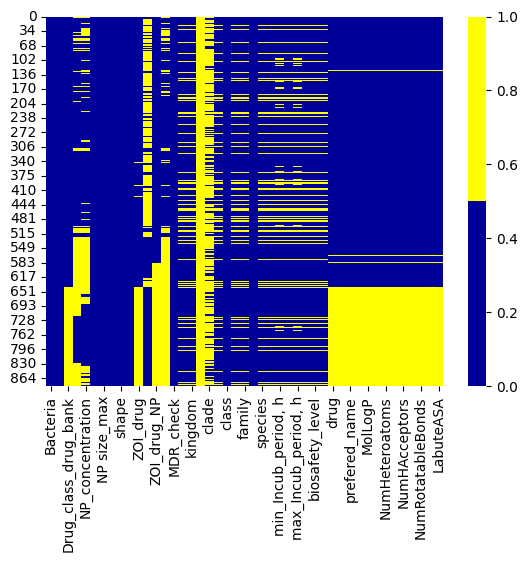

In [13]:
#поиск пустых ячеек
cols = db.columns
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00']
sns.heatmap(db[cols].isnull(), cmap=sns.color_palette(colours))
sns.set (font_scale=0.5)
# процентный список пропущенных данных
for col in db.columns:
    pct_missing = np.mean(db[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

<ipython-input-14-d15d2d3c4dfd>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = db.corr()
<ipython-input-14-d15d2d3c4dfd>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<Axes: >

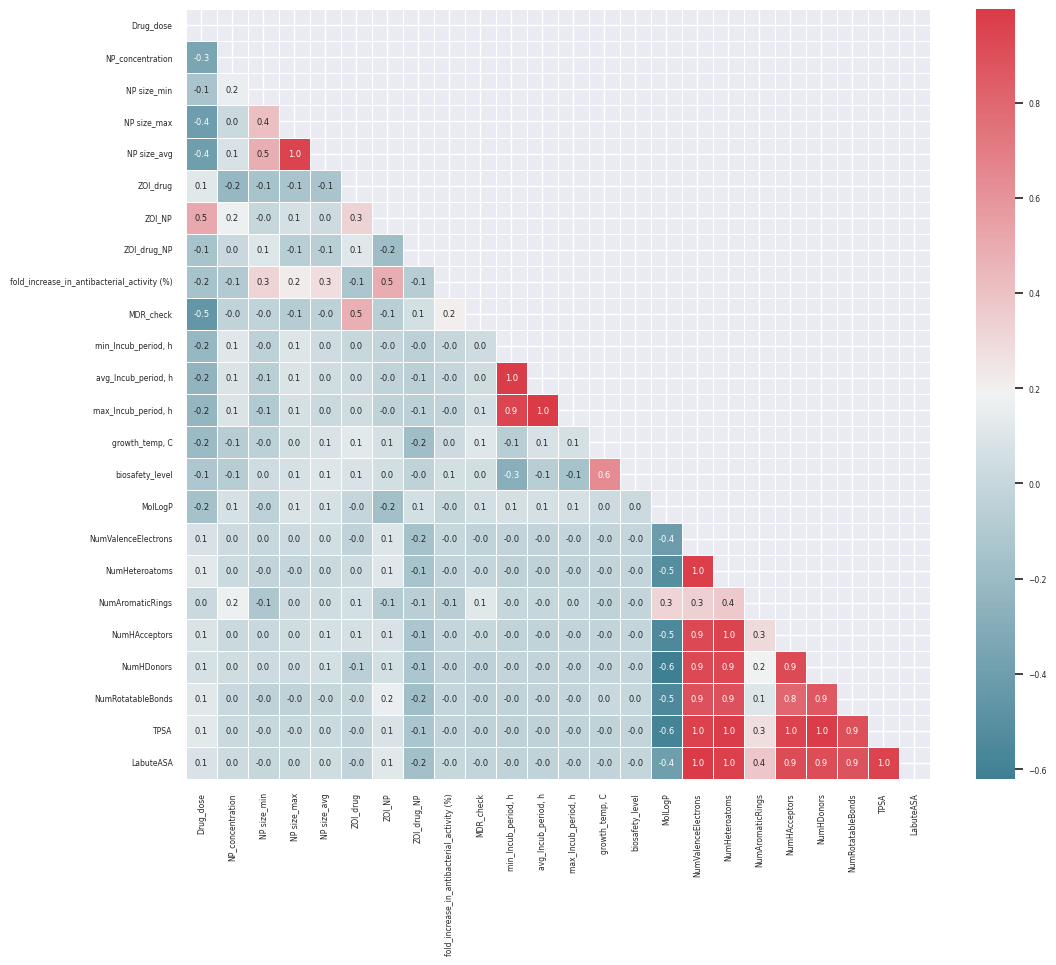

In [14]:
#Корреляционная карта
corr = db.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, linewidths=.5, mask=mask,annot=True, fmt='.1f')

Теперь удаляем id , потому что он не дает никакой информации

In [15]:
db.drop('Tax_id', axis=1, inplace=True)

Посчитаем размер данных, количество пропусков

In [16]:
db.shape

(869, 44)

In [17]:
db.isnull().sum().sum()

8546

In [18]:
db.isnull().sum()

Bacteria                                         0
NP_Synthesis                                     0
Drug_class_drug_bank                           232
Drug_dose                                      297
NP_concentration                               280
NP size_min                                      0
NP size_max                                      0
NP size_avg                                      0
shape                                            0
method                                           0
ZOI_drug                                       242
ZOI_NP                                         437
ZOI_drug_NP                                    290
fold_increase_in_antibacterial_activity (%)    448
MDR_check                                        0
kingdom                                        136
subkingdom                                     869
clade                                          626
phylum                                         136
class                          

In [19]:
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 869 entries, 0 to 882
Data columns (total 44 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Bacteria                                     869 non-null    object 
 1   NP_Synthesis                                 869 non-null    object 
 2   Drug_class_drug_bank                         637 non-null    object 
 3   Drug_dose                                    572 non-null    float64
 4   NP_concentration                             589 non-null    float64
 5   NP size_min                                  869 non-null    float64
 6   NP size_max                                  869 non-null    float64
 7   NP size_avg                                  869 non-null    float64
 8   shape                                        869 non-null    object 
 9   method                                       869 non-null    object 
 10  ZO

In [20]:
db.describe(percentiles=[.99, .01])

,Drug_dose,NP_concentration,NP size_min,NP size_max,NP size_avg,ZOI_drug,ZOI_NP,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,MolLogP,NumValenceElectrons,NumHeteroatoms,NumAromaticRings,NumHAcceptors,NumHDonors,NumRotatableBonds,TPSA,LabuteASA
count,572.000000,589.000000,869.000000,869.000000,869.000000,627.000000,432.000000,579.000000,421.000000,869.000000,703.000000,733.000000,703.000000,733.000000,733.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000
mean,275.746503,82.392148,8.933130,26.442704,18.030035,43.414083,48.525625,17.222642,319.279838,0.150748,31.559829,49.779372,72.247511,34.746248,1.836289,-1.498122,212.847134,14.159236,1.103503,11.033439,6.463376,7.807325,212.521067,228.531247
std,243.817753,183.777810,6.359834,17.477311,12.505839,154.441820,332.241911,9.760926,3763.757601,0.358009,37.190144,45.447705,54.380229,3.272839,0.370266,3.436286,169.997980,10.266006,1.161773,7.001287,7.121654,9.921839,176.200114,174.687054
min,0.000000,0.310000,1.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.160000,0.000000,12.000000,30.000000,1.000000,-10.879700,48.000000,5.000000,0.000000,2.000000,1.000000,1.000000,70.060000,46.628257
1%,0.000000,1.249600,1.000000,3.000000,3.000000,0.000000,0.000000,0.222500,0.000000,0.000000,0.160000,0.000000,12.000000,30.000000,1.000000,-10.879700,88.000000,5.000000,0.000000,4.000000,1.000000,2.000000,72.190000,93.830844
50%,500.000000,30.000000,8.000000,20.000000,13.500000,15.000000,13.000000,16.000000,0.100000,0.000000,24.000000,36.000000,48.000000,37.000000,2.000000,-0.214400,176.000000,12.000000,1.000000,10.000000,4.000000,6.000000,181.620000,189.299153
99%,500.000000,1000.000000,31.000000,80.000000,60.000000,1000.000000,180.000000,42.440000,10.880000,1.000000,240.000000,288.000000,336.000000,37.000000,2.000000,4.335420,954.000000,58.000000,5.000000,36.000000,36.000000,59.000000,981.320000,987.838232
max,500.000000,1000.000000,55.000000,80.000000,62.500000,1000.000000,4000.000000,62.500000,44774.000000,1.000000,240.000000,288.000000,336.000000,37.000000,2.000000,5.666100,954.000000,58.000000,5.000000,36.000000,36.000000,59.000000,981.320000,987.838232


In [21]:
db.nunique()

Bacteria                                       34
NP_Synthesis                                   24
Drug_class_drug_bank                           19
Drug_dose                                      15
NP_concentration                               20
NP size_min                                    15
NP size_max                                    15
NP size_avg                                    19
shape                                           3
method                                          4
ZOI_drug                                       62
ZOI_NP                                         73
ZOI_drug_NP                                    73
fold_increase_in_antibacterial_activity (%)    77
MDR_check                                       2
kingdom                                         1
subkingdom                                      0
clade                                           1
phylum                                          3
class                                           4


In [22]:
db


,Bacteria,NP_Synthesis,Drug_class_drug_bank,Drug_dose,NP_concentration,NP size_min,NP size_max,NP size_avg,shape,method,ZOI_drug,ZOI_NP,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check,kingdom,subkingdom,clade,phylum,class,order,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from,drug,chemID,prefered_name,smiles,MolLogP,NumValenceElectrons,NumHeteroatoms,NumAromaticRings,NumHAcceptors,NumHDonors,NumRotatableBonds,TPSA,LabuteASA
0,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Lactams,NaN,NaN,4.0,10.0,8.00,spherical,MIC,32.0,6.3,32.0,NaN,1,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,n,48.0,84.0,120.0,37.0,2.0,urine,Amoxicillin,CHEMBL1082,AMOXICILLIN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,0.0237,134.0,9.0,1.0,6.0,4.0,4.0,132.96,147.914892
1,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Carboxylic acids and derivatives,NaN,NaN,4.0,10.0,8.00,spherical,MIC,32.0,6.3,32.0,NaN,1,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,n,48.0,84.0,120.0,37.0,2.0,urine,Penicillin,CHEMBL1223,PENICILLIN G POTASSIUM,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,-3.4699,122.0,8.0,1.0,5.0,1.0,4.0,89.54,186.703333
2,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Lactams,NaN,NaN,15.0,30.0,28.00,spherical,MIC,32.0,25.0,32.0,NaN,1,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,n,48.0,84.0,120.0,37.0,2.0,urine,Amoxicillin,CHEMBL1082,AMOXICILLIN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,0.0237,134.0,9.0,1.0,6.0,4.0,4.0,132.96,147.914892
3,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Carboxylic acids and derivatives,NaN,NaN,15.0,30.0,28.00,spherical,MIC,32.0,25.0,32.0,NaN,1,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,n,48.0,84.0,120.0,37.0,2.0,urine,Penicillin,CHEMBL1223,PENICILLIN G POTASSIUM,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,-3.4699,122.0,8.0,1.0,5.0,1.0,4.0,89.54,186.703333
4,Micrococcus luteus,green_synthesis from fungus Aspergillus flavus,Carboxylic acids and derivatives,30.0,100.0,5.0,30.0,21.00,spherical,disc_diffusion,0.0,14.0,19.0,7.02,1,Bacteria,NaN,Terrabacteria group,Actinomycetota,Actinomycetes,Micrococcales,Micrococcaceae,Micrococcus,Micrococcus luteus,p,240.0,288.0,336.0,30.0,1.0,soil,Vancomycin,CHEMBL262777,VANCOMYCIN,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,0.1062,542.0,35.0,5.0,25.0,19.0,13.0,530.49,583.819675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,Staphylococcus aureus,green_synthesis using C. zylinicum aqueous ext...,NaN,NaN,NaN,10.0,78.9,44.45,spherical,MIC,NaN,4.5,NaN,NaN,0,Bacteria,NaN,Terrabacteria group,Bacillota,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,Staphylococcus aureus,p,24.0,36.0,48.0,37.0,2.0,skin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
879,Acinetobacter baumanii,green_synthesis using C. zylinicum aqueous ext...,NaN,NaN,NaN,10.0,78.9,44.45,spherical,MIC,NaN,5.7,NaN,NaN,0,NaN,NaN,NaN,NaN,Gammaproteobacteria,NaN,NaN,Acinetobacter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
880,Enterococcus faecalis,green_synthesis using extract of Klebsiella pn...,NaN,NaN,10.0,20.0,20.0,20.00,spherical,disc_diffusion,NaN,10.0,NaN,NaN,0,Bacteria,NaN,Terrabacteria group,Bacillota,Bacilli,Lactobacillales,Enterococcaceae,Enterococcus,Enterococcus faecalis,p,24.0,36.0,48.0,37.0,2.0,urine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
881,Enterococcus faecalis,green_synthesis using extract of Klebsiella pn...,NaN,NaN,20.0,20.0,20.0,20.00,spherical,disc_diffusion,NaN,18.0,NaN,Na

In [23]:
db.head(15)

,Bacteria,NP_Synthesis,Drug_class_drug_bank,Drug_dose,NP_concentration,NP size_min,NP size_max,NP size_avg,shape,method,ZOI_drug,ZOI_NP,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check,kingdom,subkingdom,clade,phylum,class,order,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from,drug,chemID,prefered_name,smiles,MolLogP,NumValenceElectrons,NumHeteroatoms,NumAromaticRings,NumHAcceptors,NumHDonors,NumRotatableBonds,TPSA,LabuteASA
0,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Lactams,NaN,NaN,4.00,10.00,8.0,spherical,MIC,32.0,6.3,32.0,NaN,1,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,n,48.0,84.0,120.0,37.0,2.0,urine,Amoxicillin,CHEMBL1082,AMOXICILLIN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,0.02370,134.0,9.0,1.0,6.0,4.0,4.0,132.96,147.914892
1,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Carboxylic acids and derivatives,NaN,NaN,4.00,10.00,8.0,spherical,MIC,32.0,6.3,32.0,NaN,1,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,n,48.0,84.0,120.0,37.0,2.0,urine,Penicillin,CHEMBL1223,PENICILLIN G POTASSIUM,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,-3.46990,122.0,8.0,1.0,5.0,1.0,4.0,89.54,186.703333
2,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Lactams,NaN,NaN,15.00,30.00,28.0,spherical,MIC,32.0,25.0,32.0,NaN,1,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,n,48.0,84.0,120.0,37.0,2.0,urine,Amoxicillin,CHEMBL1082,AMOXICILLIN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,0.02370,134.0,9.0,1.0,6.0,4.0,4.0,132.96,147.914892
3,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Carboxylic acids and derivatives,NaN,NaN,15.00,30.00,28.0,spherical,MIC,32.0,25.0,32.0,NaN,1,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,n,48.0,84.0,120.0,37.0,2.0,urine,Penicillin,CHEMBL1223,PENICILLIN G POTASSIUM,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,-3.46990,122.0,8.0,1.0,5.0,1.0,4.0,89.54,186.703333
4,Micrococcus luteus,green_synthesis from fungus Aspergillus flavus,Carboxylic acids and derivatives,30.0,100.0,5.00,30.00,21.0,spherical,disc_diffusion,0.0,14.0,19.0,7.02,1,Bacteria,NaN,Terrabacteria group,Actinomycetota,Actinomycetes,Micrococcales,Micrococcaceae,Micrococcus,Micrococcus luteus,p,240.0,288.0,336.0,30.0,1.0,soil,Vancomycin,CHEMBL262777,VANCOMYCIN,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,0.10620,542.0,35.0,5.0,25.0,19.0,13.0,530.49,583.819675
5,Micrococcus luteus,green_synthesis from fungus Aspergillus flavus,Aminoglycosides,10.0,100.0,5.00,30.00,21.0,spherical,disc_diffusion,0.0,14.0,19.0,7.02,1,Bacteria,NaN,Terrabacteria group,Actinomycetota,Actinomycetes,Micrococcales,Micrococcaceae,Micrococcus,Micrococcus luteus,p,240.0,288.0,336.0,30.0,1.0,soil,Gentamicin,CHEMBL463809,GENTAMICIN C1,CN[C@@H]1[C@@H](O)[C@@H](O[C@@H]2[C@@H](O)[C@H...,-3.32750,194.0,12.0,0.0,12.0,8.0,7.0,199.73,194.976878
6,Staphylococcus aureus,green_synthesis using Dioscorea bulbifera tube...,Lactams,500.0,30.0,8.00,20.00,13.5,nanorods and triangles,disc_diffusion,12.0,NaN,15.0,0.60,0,Bacteria,NaN,Terrabacteria group,Bacillota,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,Staphylococcus aureus,p,24.0,36.0,48.0,37.0,2.0,skin,Ceftazidime,CHEMBL44354,CEFTAZIDIME,CC(C)(O/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=...,-1.29920,194.0,15.0,2.0,11.0,3.0,9.0,191.22,218.156211
7,Staphylococcus epidermidis,chem_synthesis by silver nitrate,Aminoglycosides,NaN,NaN,20.00,40.00,30.0,spherical,MIC,500.0,NaN,62.5,NaN,1,Bacteria,NaN,Terrabacteria group,Bacillota,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,Staphylococcus epidermidis,p,24.0,36.0,48.0,37.0,2.0,nose,Gentamicin,CHEMBL463809,GENTAMICIN C1,CN[C@@H]1[C@@H](O)[C@@H](O[C@@H]2[C@@H]

Убираем пропущенные значения zoi_drug_np вот тут:

In [24]:
pass

In [68]:
db_without_nulls_in_target = db.drop(db[db['ZOI_drug_NP'].isnull()].index, axis=0)
target = db_without_nulls_in_target['ZOI_drug_NP']
db_without_nulls_in_target.drop('ZOI_drug_NP', axis=1, inplace=True)
db_without_nulls_in_target.shape

(579, 43)

In [69]:
def target_imputer(target):
  a = None
  try:
    a = eval(target)
  except:
    print(target)
    if target is None or type(target) == float:
      return target
    a = target.split('+')
    a = [eval(i) for i in a if i][0]
  return a


target = target.apply(target_imputer)
clear_output()

In [70]:
target.isnull().sum()

0

Убираем выбросы вот тут

In [71]:
db_without_nulls_in_target[(db_without_nulls_in_target['Bacteria'] == 'Acinetobacter baumanii') & (db_without_nulls_in_target['ZOI_NP'] == 1000)] = 13.6
db_without_nulls_in_target[(db_without_nulls_in_target['Bacteria'] == 'Escherichia coli') & (db_without_nulls_in_target['ZOI_NP'] == 1000)] = 11
db_without_nulls_in_target[(db_without_nulls_in_target['Bacteria'] == 'Proteus sp.') & (db_without_nulls_in_target['ZOI_NP'] == 1000)] = 17.8
db_without_nulls_in_target[(db_without_nulls_in_target['Bacteria'] == 'Pseudomonas aeruginosa') & (db_without_nulls_in_target['ZOI_NP'] == 1000)] = 16
db_without_nulls_in_target[(db_without_nulls_in_target['Bacteria'] == 'Klebsiella sp') & (db_without_nulls_in_target['ZOI_NP'] == 1000)] = 17.8

Переведем бактерии в веткторные признаки

In [72]:
bacteria_dict = {
    'Acinetobacter': '1000010001',
    'Actinobacillus': '1010001111',
    'Bacillus': '1001110101',
    'Enterococcus': '1000100100',
    'Enterobacter': '0010000101',
    'Escherichia': '0010000101',
    'Haemophilus': '0010000110',
    'Klebsiella': '0010000100',
    'Listeria': '0010100101',
    'Micrococcus': '1010101011',
    'Neisseria': '0100010111',
    'Pasteurella': '0010000111',
    'Proteus': '0010010001',
    'Pseudomonas': '0011010011',
    'Salmonella': '0010000101',
    'Serratia': '0010000101',
    'Staphylococcus': '1000100101',
    'Streptococcus': '1000100111',
    'Vibrio': '0110000101'
}
def get_vactors_bact(bac):
    if bac.split(' ')[0] == 'Candida':
      # print('çandida')
      bact = [-1] * 10
    else:
      bact = list(map(float, list(bacteria_dict[bac.split(' ')[0]])))
    return pd.Series(bact)

bac_vect = pd.DataFrame(db_without_nulls_in_target['Bacteria'].apply(get_vactors_bact))
bac_vect.columns = [f'bac_{i}' for i in range(10)]

db_without_nulls_in_target = pd.concat([db_without_nulls_in_target, bac_vect], axis=1)
db_without_nulls_in_target

,Bacteria,NP_Synthesis,Drug_class_drug_bank,Drug_dose,NP_concentration,NP size_min,NP size_max,NP size_avg,shape,method,ZOI_drug,ZOI_NP,fold_increase_in_antibacterial_activity (%),MDR_check,kingdom,subkingdom,clade,phylum,class,order,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from,drug,chemID,prefered_name,smiles,MolLogP,NumValenceElectrons,NumHeteroatoms,NumAromaticRings,NumHAcceptors,NumHDonors,NumRotatableBonds,TPSA,LabuteASA,bac_0,bac_1,bac_2,bac_3,bac_4,bac_5,bac_6,bac_7,bac_8,bac_9
0,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Lactams,NaN,NaN,4.0,10.0,8.0,spherical,MIC,32.0000,6.3,NaN,1.0,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,n,48.0,84.0,120.0,37.0,2.0,urine,Amoxicillin,CHEMBL1082,AMOXICILLIN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,0.0237,134.0,9.0,1.0,6.0,4.0,4.0,132.96,147.914892,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Carboxylic acids and derivatives,NaN,NaN,4.0,10.0,8.0,spherical,MIC,32.0000,6.3,NaN,1.0,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,n,48.0,84.0,120.0,37.0,2.0,urine,Penicillin,CHEMBL1223,PENICILLIN G POTASSIUM,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,-3.4699,122.0,8.0,1.0,5.0,1.0,4.0,89.54,186.703333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Lactams,NaN,NaN,15.0,30.0,28.0,spherical,MIC,32.0000,25.0,NaN,1.0,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,n,48.0,84.0,120.0,37.0,2.0,urine,Amoxicillin,CHEMBL1082,AMOXICILLIN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...,0.0237,134.0,9.0,1.0,6.0,4.0,4.0,132.96,147.914892,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Carboxylic acids and derivatives,NaN,NaN,15.0,30.0,28.0,spherical,MIC,32.0000,25.0,NaN,1.0,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,n,48.0,84.0,120.0,37.0,2.0,urine,Penicillin,CHEMBL1223,PENICILLIN G POTASSIUM,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,-3.4699,122.0,8.0,1.0,5.0,1.0,4.0,89.54,186.703333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,Micrococcus luteus,green_synthesis from fungus Aspergillus flavus,Carboxylic acids and derivatives,30.0,100.0,5.0,30.0,21.0,spherical,disc_diffusion,0.0000,14.0,7.02,1.0,Bacteria,NaN,Terrabacteria group,Actinomycetota,Actinomycetes,Micrococcales,Micrococcaceae,Micrococcus,Micrococcus luteus,p,240.0,288.0,336.0,30.0,1.0,soil,Vancomycin,CHEMBL262777,VANCOMYCIN,CN[C@H](CC(C)C)C(=O)N[C@H]1C(=O)N[C@@H](CC(N)=...,0.1062,542.0,35.0,5.0,25.0,19.0,13.0,530.49,583.819675,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,Staphylococcus aureus,chem_synthesis_reduction_by_D_maltose,Carboxylic acids and derivatives,NaN,NaN,4.0,10.0,8.0,spherical,MIC,1.0000,25.0,NaN,0.0,Bacteria,NaN,Terrabacteria group,Bacillota,Bacilli,Bacillales,Staphylococcaceae,Staphylococcus,Staphylococcus aureus,p,24.0,36.0,48.0,37.0,2.0,skin,Penicillin,CHEMBL1223,PENICILLIN G POTASSIUM,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,-3.4699,122.0,8.0,1.0,5.0,1.0,4.0,89.54,186.703333,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
580,Pseudomonas aeruginosa,green_synthesis from fungus Phytophthora infe...,Fatty Acyls,NaN,NaN,5.0,80.0,60.0,spherical,MIC,0.3125,2.5,NaN,0.0,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,Pseudomonas aeruginosa group,n,24.0,48.0,72.0,37.0,2.0,soil,mupirocin,CHEMBL719,MUPIROCIN,C/C(=C\C(=O)OCCC

Переводим Smiles в векторы признаков тут

In [30]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e
!pip install --pre deepchem
import deepchem
from rdkit import Chem
deepchem.__version__
!git clone https://github.com/NVIDIA/apex
!cd /content/apex
!pip install -v --no-cache-dir /content/apex
!pip install transformers
!pip install simpletransformers
!pip install wandb
!cd ..
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex
!git clone https://github.com/seyonechithrananda/bert-loves-chemistry.git
!nvidia-smi
# Test if NVIDIA apex training tool works
clear_output()

Окружение установлено, теперь загрузим предобученную модель и попробуем посмотреть, что у нее получается на выходе. Возможно ее можем дообучить

In [73]:
from transformers import RobertaForCausalLM, RobertaTokenizer, pipeline, AutoConfig, RobertaConfig
# config = AutoConfig.from_pretrained("roberta-base")

tokenizer = RobertaTokenizer.from_pretrained("gokceuludogan/ChemBERTaLM")
model = RobertaForCausalLM.from_pretrained("gokceuludogan/ChemBERTaLM", output_hidden_states=True )
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)
generator("", max_length=128, do_sample=True)

[{'generated_text': 'CC(CNC(=O)c1nc2ccccc2s1)c1cccs1'}]

In [74]:
import torch
from tqdm import tqdm
def get_nlp_embadding(smile): # возможно неправильно и лучше брать просто брать последний вектор из скрытого слоя. Это можно будет отследить, когда будем улучшать качество моделей
  f = [0] * 768
  if smile and type(smile) != float:
    input = tokenizer.encode(smile, return_tensors="pt")
    token_logits = model(input)
    sentence_embedding = torch.mean(token_logits.hidden_states[6], 1)
    f  = sentence_embedding.squeeze().detach().numpy()
  return pd.Series(f)

In [75]:
tqdm.pandas()
smiles = pd.DataFrame(db_without_nulls_in_target.smiles.progress_apply(get_nlp_embadding))
smiles.columns = list(f'smiles_v_{i}' for i in range(768))

100%|██████████| 579/579 [02:31<00:00,  3.81it/s]


In [76]:
db_without_nulls_in_target = pd.concat([db_without_nulls_in_target, smiles], axis=1).drop(['smiles','Bacteria'], axis=1)
db_without_nulls_in_target

NP_Synthesis  \
0                chem_synthesis_reduction_by_D_maltose   
1                chem_synthesis_reduction_by_D_maltose   
2                chem_synthesis_reduction_by_D_maltose   
3                chem_synthesis_reduction_by_D_maltose   
4      green_synthesis from fungus  Aspergillus flavus   
..                                                 ...   
579              chem_synthesis_reduction_by_D_maltose   
580  green_synthesis from fungus  Phytophthora infe...   
581              chem_synthesis_reduction_by_D_maltose   
582              chem_synthesis_reduction_by_D_maltose   
583  green_synthesis from fungus  Phytophthora infe...   

                 Drug_class_drug_bank  Drug_dose  NP_concentration  \
0                             Lactams        NaN               NaN   
1    Carboxylic acids and derivatives        NaN               NaN   
2                             Lactams        NaN               NaN   
3    Carboxylic acids and derivatives        NaN               NaN   
4    Carboxylic acids and derivatives       30.0             100.0   
..                                ...        ...               ...   
579  Carboxylic acids and derivatives        NaN               NaN   
580                       Fatty Acyls        NaN               NaN   
581  Carboxylic acids and derivatives        NaN               NaN   
582  Carboxylic acids and derivatives        NaN               NaN   
583                                NC        NaN               NaN   

     NP size_min  NP size_max  NP size_avg      shape          method  \
0            4.0         10.0          8.0  spherical             MIC   
1            4.0         10.0          8.0  spherical             MIC   
2           15.0         30.0         28.0  spherical             MIC   
3           15.0         30.0         28.0  spherical             MIC   
4            5.0         30.0         21.0  spherical  disc_diffusion   
..           ...          ...          ...        ...             ...   
579          4.0         10.0          8.0  spherical             MIC   
580          5.0         80.0         60.0  spherical             MIC   
581          4.0         10.0          8.0  spherical             MIC   
582         15.0         30.0         28.0  spherical             MIC   
583          5.0         80.0         60.0  spherical             MIC   

     ZOI_drug  ZOI_NP  fold_increase_in_antibacterial_activity (%)  MDR_check  \
0     32.0000     6.3                                          NaN        1.0   
1     32.0000     6.3                                          NaN        1.0   
2     32.0000    25.0                                          NaN        1.0   
3     32.0000    25.0                                          NaN        1.0   
4      0.0000    14.0                                         7.02        1.0   
..        ...     ...                                          ...        ...   
579    1.0000    25.0                                          NaN        0.0   
580    0.3125     2.5                                          NaN        0.0   
581    0.0300   100.0                                          NaN        0.0   
582    0.0300    50.0                                          NaN        0.0   
583    2.5000     2.5                                          NaN        0.0   

      kingdom subkingdom                clade          phylum  \
0    Bacteria        NaN                  NaN  Pseudomonadota   
1    Bacteria        NaN                  NaN  Pseudomonadota   
2    Bacteria        NaN                  NaN  Pseudomonadota   
3    Bacteria        NaN                  NaN  Pseudomonadota   
4    Bacteria        NaN  Terrabacteria group  Actinomycetota   
..        ...        ...                  ...             ...   
579  Bacteria        NaN  Terrabacteria group       Bacillota   
580  Bacteria        NaN                  NaN  Pseudomonadota   
581  Bacteria        NaN                  NaN  Pseudomonadota   
582 

In [77]:
# разделим на категориальный и числовые

text_columns = db_without_nulls_in_target.select_dtypes(include='object').columns.tolist()

numeric_columns = db_without_nulls_in_target.select_dtypes(include=numerics).columns.tolist()

In [78]:
db[text_columns].head(3)

,NP_Synthesis,Drug_class_drug_bank,shape,method,kingdom,subkingdom,clade,phylum,class,order,family,genus,species,gram,isolated_from,drug,chemID,prefered_name
0,chem_synthesis_reduction_by_D_maltose,Lactams,spherical,MIC,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,n,urine,Amoxicillin,CHEMBL1082,AMOXICILLIN
1,chem_synthesis_reduction_by_D_maltose,Carboxylic acids and derivatives,spherical,MIC,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,n,urine,Penicillin,CHEMBL1223,PENICILLIN G POTASSIUM
2,chem_synthesis_reduction_by_D_maltose,Lactams,spherical,MIC,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,n,urine,Amoxicillin,CHEMBL1082,AMOXICILLIN


In [79]:

def convert_to_int(X):
    X= X.round().astype(np.float64) # Change columns 2 and 4 to int
    return X

int_converter = FunctionTransformer(convert_to_int)

class OrdinalDecoder(BaseEstimator, TransformerMixin):
    def __init__(self):
      pass
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return ordinal_encoder.inverse_transform(X)

    def fit_transform(self, X, y=None):
        return ordinal_encoder.inverse_transform(X)

    def get_feature_names_out(self, *args, **params):
        return text_columns
from sklearn.impute import SimpleImputer


ordinal_encoder = OrdinalEncoder(encoded_missing_value=-100, handle_unknown='use_encoded_value', unknown_value=-1)
ordinal_encoder.fit(db[text_columns])
global tfidf_1
global hash_vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
hash_vec = HashingVectorizer()
tfidf_1 = TfidfVectorizer(min_df=0)
# print('1   ', ordinal_encoder.categories_) # запустив эту строчку,
# можно посмотреть на то, какие переменные закодированы
ordinal_decoder = OrdinalDecoder()
numerical_transformer = Pipeline(
    steps=[

          ('label_encoder', ordinal_encoder),
          ('imputer', KNNImputer(missing_values=-100, n_neighbors=3)), # находим самые похожие семплы и определяем пропущенное значение как среднее в этих семплах
          # ('type_conversion', int_converter),
          # ('label_decoder',  OrdinalDecoder())
          # ('imputer',  SimpleImputer(missing_values=np.nan, strategy='constant')),
          # ('label_encoder', ordinal_encoder),
        # ('encoder', OneHotEncoder()),
        ('scaler', StandardScaler())
    ]
)

smiles_transformer = Pipeline(
    steps=[
        ('tdidfVec', tfidf_1)
        # ('hashVec', hash_vec)
    ]
)

ratio_transformer = Pipeline(
    steps=[
          ('imputer', KNNImputer(n_neighbors=3)),
        # ('imputer', IterativeImputer(random_state=0)),

        # ('encoder', OneHotEncoder()),
        # ('scaler', RobustScaler())
    ]
)


column_transformer = ColumnTransformer([
    # ('replace unknown with none', FunctionTransformer(replace_unknown), df.columns),
    # ('c',numerical_transformer, [i for i in text_columns if i != 'smiles']),
        ('c',numerical_transformer, text_columns),
    ('r',ratio_transformer, numeric_columns),
    # ('smile', smiles_transformer, ['smiles'])
]
)
column_transformer.set_output(transform='pandas') # вот такой трансформер получился
column_transformer

ColumnTransformer(transformers=[('c',
                                 Pipeline(steps=[('label_encoder',
                                                  OrdinalEncoder(encoded_missing_value=-100,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('imputer',
                                                  KNNImputer(missing_values=-100,
                                                             n_neighbors=3)),
                                                 ('scaler', StandardScaler())]),
                                 ['NP_Synthesis', 'Drug_class_drug_bank',
                                  'shape', 'method', 'kingdom', 'subkingdom',
                                  'clade', 'phylum',...
                                  'fold_increase_in_antibacterial_activity (%)',
                                  'MDR_check', 'min_Incub_period, h',
                                  'avg_Incub_period, h', 'max_Incub_period, h',
                                  'growth_temp, C', 'biosafety_level',
                                  'MolLogP', 'NumValenceElectrons',
                                  'NumHeteroatoms', 'NumAromaticRings',
                                  'NumHAcceptors', 'NumHDonors',
                                  'NumRotatableBonds', 'TPSA', 'LabuteASA',
                                  'bac_0', 'bac_1', 'bac_2', 'bac_3', 'bac_4',
                                  'bac_5', 'bac_6', ...])])

In [80]:
X_train, X_test, y_train, y_test = train_test_split(db_without_nulls_in_target, target)

In [81]:
clf = RandomForestRegressor(n_estimators = 1000)

In [82]:
from sklearn.linear_model import Lasso
pipe = Pipeline(steps=[
    ('transform', column_transformer),
    ('selector', SelectFromModel(estimator=Lasso(max_iter=50000, alpha=0.1))),
    ('clf', clf)
])

In [83]:
pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)

In [84]:
rmse = mean_squared_error(y_test, predicted, squared=False)
print('rmse =  ', rmse) # бейзлайн построен и он имеет вот такую ошибку.
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predicted)
print('r2_score =  ', r2) # бейзлайн построен и он имеет вот такую ошибку.
# дальше будем проверять работу других моделей и думать, как и что улучшить.

rmse =   4.397146731304053
r2_score =   0.7993563748578091


In [85]:
# https://stackoverflow.com/questions/55858788/is-it-possible-to-add-transformedtargetregressor-into-a-scikit-learn-pipeline
stat = []
cv = ShuffleSplit(n_splits=5, test_size=.25, random_state=1)
# создадим удобную функцию для измерения всего и вся



def model(clf, stat, X_train, y_train, X_test, y_test, cv, make_plot=False, test=False):
    pipe = Pipeline(steps=[
    ('transform', column_transformer),
    ('selector', SelectFromModel(estimator=Lasso(max_iter=50000, alpha=1))),
    ('clf', clf)])
#     model_prepared = TransformedTargetRegressor(regressor=pipe,
#                                    func=np.log1p,
#                                    inverse_func=np.expm1)
    model_prepared = pipe

    if test:
        model_prepared.fit(X_train, y_train)
        predicted = model_prepared.predict(X_test)
        return predicted
    cv_sc = cross_validate(model_prepared ,X_train, y_train, cv=cv, scoring=make_scorer(mean_squared_error),
                           return_train_score=True)
    av_fit_time = cv_sc['fit_time'].mean()
    av_score_time = cv_sc['score_time'].mean()
    test_score = cv_sc['test_score'].mean()
    train_score = cv_sc['train_score'].mean()
    test_score_all =  cv_sc['test_score']

    return train_score, test_score, cv_sc['test_score'].mean(), test_score_all

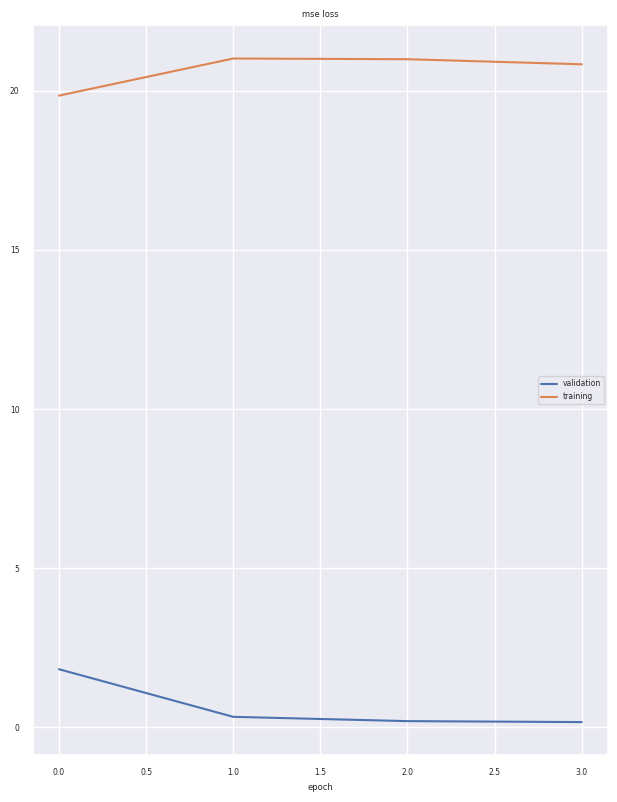

mse loss
	validation       	 (min:    0.169, max:    1.829, cur:    0.169)
	training         	 (min:   19.842, max:   21.007, cur:   20.826)
Для данной модели усредненное rmse на тестовых данных при валидации:  20.825583243968886
CPU times: user 42.4 s, sys: 12.7 s, total: 55.1 s
Wall time: 51.4 s


In [86]:
%%time
gr = list(range(100, 1500, 400))
liveloss = PlotLosses()
for i, j in enumerate(gr):
    logs = {}
    gb = GradientBoostingRegressor(learning_rate=0.2, n_estimators=j, criterion='squared_error', max_features='log2')
    train, test, rmse, st = model(gb,
          stat, X_train, y_train, X_test, y_test, cv)
    logs['val_mse loss'] = train
    logs['mse loss'] = test
    liveloss.update(logs)
    liveloss.send()
stat.append(st) # добавляем самый последний результат
print('Для данной модели усредненное rmse на тестовых данных при валидации: ', rmse )# выводим последний результат

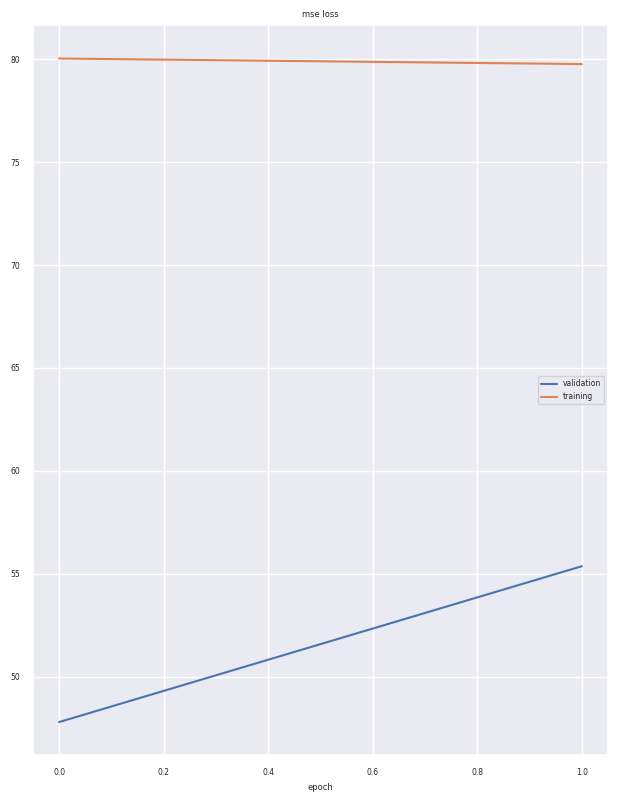

mse loss
	validation       	 (min:   47.791, max:   55.365, cur:   55.365)
	training         	 (min:   79.769, max:   80.039, cur:   79.769)
Для данной модели усредненное rmse на тестовых данных при валидации:  79.7686321875
CPU times: user 15.3 s, sys: 6.19 s, total: 21.5 s
Wall time: 18.8 s


In [87]:
%%time
gr = list(range(5, 10, 3))
liveloss = PlotLosses()
for i, j in enumerate(gr):
    logs = {}
    kn = KNeighborsRegressor(n_jobs=-1, n_neighbors=j)
    train, test, rmse, st = model(kn,
          stat, X_train, y_train, X_test, y_test, cv)
    logs['val_mse loss'] = train
    logs['mse loss'] = test
    liveloss.update(logs)
    liveloss.send()
stat.append(st) # добавляем самый последний результат
print('Для данной модели усредненное rmse на тестовых данных при валидации: ', rmse )# выводим последний результат


In [88]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split


clf = MLPRegressor(random_state=1, max_iter=50000, hidden_layer_sizes=(500, 400, 200, 100, 10, 10, 10, 10))
pipe = Pipeline(steps=[
    ('transform', column_transformer),
    ('selector', SelectFromModel(estimator=Lasso(max_iter=50000, alpha=0.01))),
    ('clf', clf)
])


In [89]:
pipe.fit(X_train, y_train)

predicted = pipe.predict(X_test)
rmse = mean_squared_error(y_test, predicted, squared=False)
print('rmse =  ', rmse) # бейзлайн построен и он имеет вот такую ошибку.
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predicted)
print('r2_score =  ', r2) # бейзлайн построен и он имеет вот такую ошибку.
# дальше будем проверять работу других моделей и думать, как и что улучшить.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.103e+03, tolerance: 4.109e+00
  model = cd_fast.enet_coordinate_descent(


rmse =   7.468886136571591
r2_score =   0.42111122698148973


In [90]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

  Using cached jedi-0.18.2-py2.py3-none-any.whl (1.6 MB)
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [91]:

def convert_to_int(X):
    X= X.round().astype(np.float64) # Change columns 2 and 4 to int
    return X

int_converter = FunctionTransformer(convert_to_int)

class OrdinalDecoder(BaseEstimator, TransformerMixin):
    def __init__(self):
      pass
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return ordinal_encoder.inverse_transform(X)

    def fit_transform(self, X, y=None):
        return ordinal_encoder.inverse_transform(X)

    def get_feature_names_out(self, *args, **params):
        return text_columns
from sklearn.impute import SimpleImputer


ordinal_encoder = OrdinalEncoder(encoded_missing_value=-100, handle_unknown='use_encoded_value', unknown_value=-1)
ordinal_encoder.fit(db[text_columns])
global tfidf_1
global hash_vec

hash_vec = HashingVectorizer()
tfidf_1 = TfidfVectorizer(min_df=0)
# print('1   ', ordinal_encoder.categories_) # запустив эту строчку,
# можно посмотреть на то, какие переменные закодированы
ordinal_decoder = OrdinalDecoder()
numerical_transformer = Pipeline(
    steps=[

          ('label_encoder', ordinal_encoder),
          ('imputer', KNNImputer(missing_values=-100, n_neighbors=3)), # находим самые похожие семплы и определяем пропущенное значение как среднее в этих семплах
          ('type_conversion', int_converter),
          ('label_decoder',  OrdinalDecoder()),
          ('imputer2',  SimpleImputer(strategy='most_frequent')),
          # ('label_encoder', ordinal_encoder),
        # ('encoder', OneHotEncoder()),
        # ('scaler', StandardScaler())
    ]
)

ratio_transformer = Pipeline(
    steps=[
          ('imputer', KNNImputer(n_neighbors=3)),
        # ('imputer', IterativeImputer(random_state=0)),

        # ('encoder', OneHotEncoder()),
        # ('scaler', RobustScaler())
    ]
)


column_transformer = ColumnTransformer([
    # ('replace unknown with none', FunctionTransformer(replace_unknown), df.columns),
    # ('c',numerical_transformer, [i for i in text_columns if i != 'smiles']),
        ('c',numerical_transformer, text_columns),
    ('r',ratio_transformer, numeric_columns)
    # ('smile', smiles_transformer, ['smiles'])
]
)
column_transformer.set_output(transform='pandas') # вот такой трансформер получился
X_train1 = column_transformer.fit_transform(X_train)
X_test1 = column_transformer.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


ValueError: ignored

In [ ]:
s = SimpleImputer(strategy='most_frequent')
s.fit(X_train1)
for i in X_test1.columns[X_test1.isnull().any()]:
  X_test1[i] = X_test1[i].fillna(method='ffill')
X_test1.isnull().any()

In [ ]:
import numpy as np
from catboost import Pool, CatBoostRegressor
# initialize data
train_data = X_train1
train_label = y_train
test_data = X_test1
# initialize Pool



train_pool = Pool(train_data,
                  train_label,
                  cat_features=['c__' + i for i in text_columns]
                  )
test_pool = Pool(test_data,
                 cat_features=['c__' + i for i in text_columns]
                 )

# specify the training parameters
model = CatBoostRegressor(iterations=8000,
                          depth=5,
                          learning_rate=0.043,
                          loss_function='RMSE')
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
predicted = model.predict(test_pool)
rmse = mean_squared_error(y_test, predicted, squared=False)
print('rmse =  ', rmse) # бейзлайн построен и он имеет вот такую ошибку.
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predicted)
print('r2_score =  ', r2) # бейзлайн построен и он имеет вот такую ошибку.
# дальше будем проверять работу других моделей и думать, как и что улучшить.

Задачи
0. Добавить данные про наночастицы серебра Ag ( они везде использовались)
1.    докинуть данные из NCBI про бактерии
2.   докинуть данные из rdkit и других библиотек по smiles
3.    разобраться с пропусками
4. выделить целевую переменную
5.   закодировать категориальные признаки, отмасштабировать данные
6. разбить на трейн - тест
На этом предобработка данных заканчивается. Нужно будет строить различные модели и оченивать их перформанс



Код, который использовался для дебага (null label encoder, general transformers etc

In [ ]:


###############################################################################################################


###############################################################################################################



###############################################################################################################

# token_embeddings = []
# import torch

# # For each token in the sentence...
# for token_i in range(token_logits.hidden_states[1].size()[1]):

#   # Holds 12 layers of hidden states for each token
#   hidden_layers = []

#   # For each of the 12 layers...
#   for layer_i in range(len(token_logits.hidden_states)):

#     # Lookup the vector for `token_i` in `layer_i`
#     vec = token_logits.hidden_states[layer_i][0][token_i]

#     hidden_layers.append(vec)

#   token_embeddings.append(hidden_layers)

# # Sanity check the dimensions:
# print ("Number of tokens in sequence:", len(token_embeddings))

# summed_last_4_layers = [torch.sum(torch.stack(layer)[-4:], 0) for layer in token_embeddings]
# len(summed_last_4_layers)

###############################################################################################################
